# Train a JointVAE model

In [108]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [109]:
import numpy as np
import torch

use_cuda = torch.cuda.is_available()
use_cuda

True

In [110]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # change to your device

#### Prepare data list

In [111]:
!ls data

dress_dresslen_train_test_splits.json  dress_sleevelen_train_test_splits.json
dress_sleeve_train_test_splits.json    loadable_women_primary_dress.csv


#### Create list of image paths

In [112]:
#loadable_dresses = list(np.loadtxt('data/loadable_women_primary_dress.csv',delimiter=',',skiprows=1,dtype='str'))

In [113]:
#print(len(loadable_dresses))

In [114]:
#loadable_dresses[:5]

In [115]:
!ls /workspace/mnt/crucial_2TB/111_Extra_Data/Macys/

imgs224_1000  xtrain3150_260260.csv  xtrainonly1000.csv


In [116]:
dir_name = '/workspace/mnt/crucial_2TB/111_Extra_Data/Macys/imgs224_1000/'
files = [dir_name + x for x in os.listdir(dir_name)]
files[:3]

['/workspace/mnt/crucial_2TB/111_Extra_Data/Macys/imgs224_1000/_13.png',
 '/workspace/mnt/crucial_2TB/111_Extra_Data/Macys/imgs224_1000/_280.png',
 '/workspace/mnt/crucial_2TB/111_Extra_Data/Macys/imgs224_1000/_683.png']

In [117]:
len(files)

1001

#### Split into train and test set

In [118]:
#image_paths_train = loadable_dresses[:88800]
#image_paths_test = loadable_dresses[88800:-124]
image_paths_train = files[:800]
image_paths_test = files[800:]


print(f"Number of train image paths: {len(image_paths_train):,d}")
print(f"Number of test image paths: {len(image_paths_test):,d}")
print()
print("Sample paths:")
print(image_paths_train[0])
print(image_paths_train[-1])
print(image_paths_test[0])
print(image_paths_test[-1])

Number of train image paths: 800
Number of test image paths: 201

Sample paths:
/workspace/mnt/crucial_2TB/111_Extra_Data/Macys/imgs224_1000/_13.png
/workspace/mnt/crucial_2TB/111_Extra_Data/Macys/imgs224_1000/_17.png
/workspace/mnt/crucial_2TB/111_Extra_Data/Macys/imgs224_1000/_387.png
/workspace/mnt/crucial_2TB/111_Extra_Data/Macys/imgs224_1000/_48.png


In [120]:
from torchvision import transforms
#from utils.dataloaders_custom import get_imagelist_dataloader, ImageListDataset
from utils.dataloader_tools import get_imagelist_dataloader, ImageListDataset

BATCH_SIZE = 32

composed = transforms.Compose([transforms.CenterCrop((90,90)),transforms.Resize((64,64)),transforms.ToTensor()])

# convert rgb is for the cv2 loaded images that I've got in this dir
train_dataset = ImageListDataset(image_paths_train, cut_from='top', cut_amount=90, transform=composed, convert_rgb=True)
test_dataset = ImageListDataset(image_paths_test, cut_from='top', cut_amount=90, transform=composed, convert_rgb=True)

train_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=train_dataset)
test_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=test_dataset)

### Define latent distribution of the model

In [147]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 10,
               'disc': [30]}

### Build a model

In [148]:
!ls jointvae

__init__.py	       models_128_v1.py     models_64_xstyle_finished_v1.py
__pycache__	       models_128_v2.py     models_64_xstyle_int_debug.py
decoder_scratchpad.py  models_128_v3.py     models_64_xstyle_int_nd.py
encoder_scratchpad.py  models_128_v4.py     training.py
models.py	       models_64_xstyle.py  training_debug.py


In [165]:
#from jointvae.models_64_xstyle_int_nd import VAE
from jointvae.models_64_xstyle_int_debug import VAE


#model = VAE(latent_spec=latent_spec, img_size=(3, 260, 260), use_cuda=use_cuda)
model = VAE(latent_spec=latent_spec, img_size=(3, 64, 64), use_cuda=use_cuda)

In [166]:
#print(model)

### Train the model

In [167]:
from torch import optim

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, amsgrad=True) # added amsgrad # orig lr 5e-4

In [168]:
from jointvae.training import Trainer
#from jointvae.training_debug import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity,
                 use_cuda=use_cuda)

#### Initialize visualizer

In [169]:
#from viz.visualize import Visualizer
from viz.visualize import Visualizer

viz = Visualizer(model)
viz.save_images = False # needed to add this so it returns a tensor

In [170]:
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo

trainer.train(train_loader, epochs=10, save_training_gif=None)

features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
0/800	Loss: 2844.217
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decode

features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoi

features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoi

features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoi

features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoi

features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoi

0/800	Loss: 2465.970
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decode

features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoi

In [171]:
print('hi')

hi


In [172]:
# Get a batch of data
for batch, labels in test_loader:
    break
print("batch: ",type(batch),batch.shape)
type(viz.reconstructions(batch))

batch:  <class 'torch.Tensor'> torch.Size([32, 3, 64, 64])
features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])


torch.Tensor

### Visualize

features shape:  torch.Size([32, 64, 4, 4])
features view shape:  torch.Size([32, 1024])
latent dist keys in decode:  dict_keys(['cont', 'disc'])
latent sample shape in decode:  torch.Size([32, 40])
decoded shape before sigmoid:  torch.Size([32, 3, 64, 64])


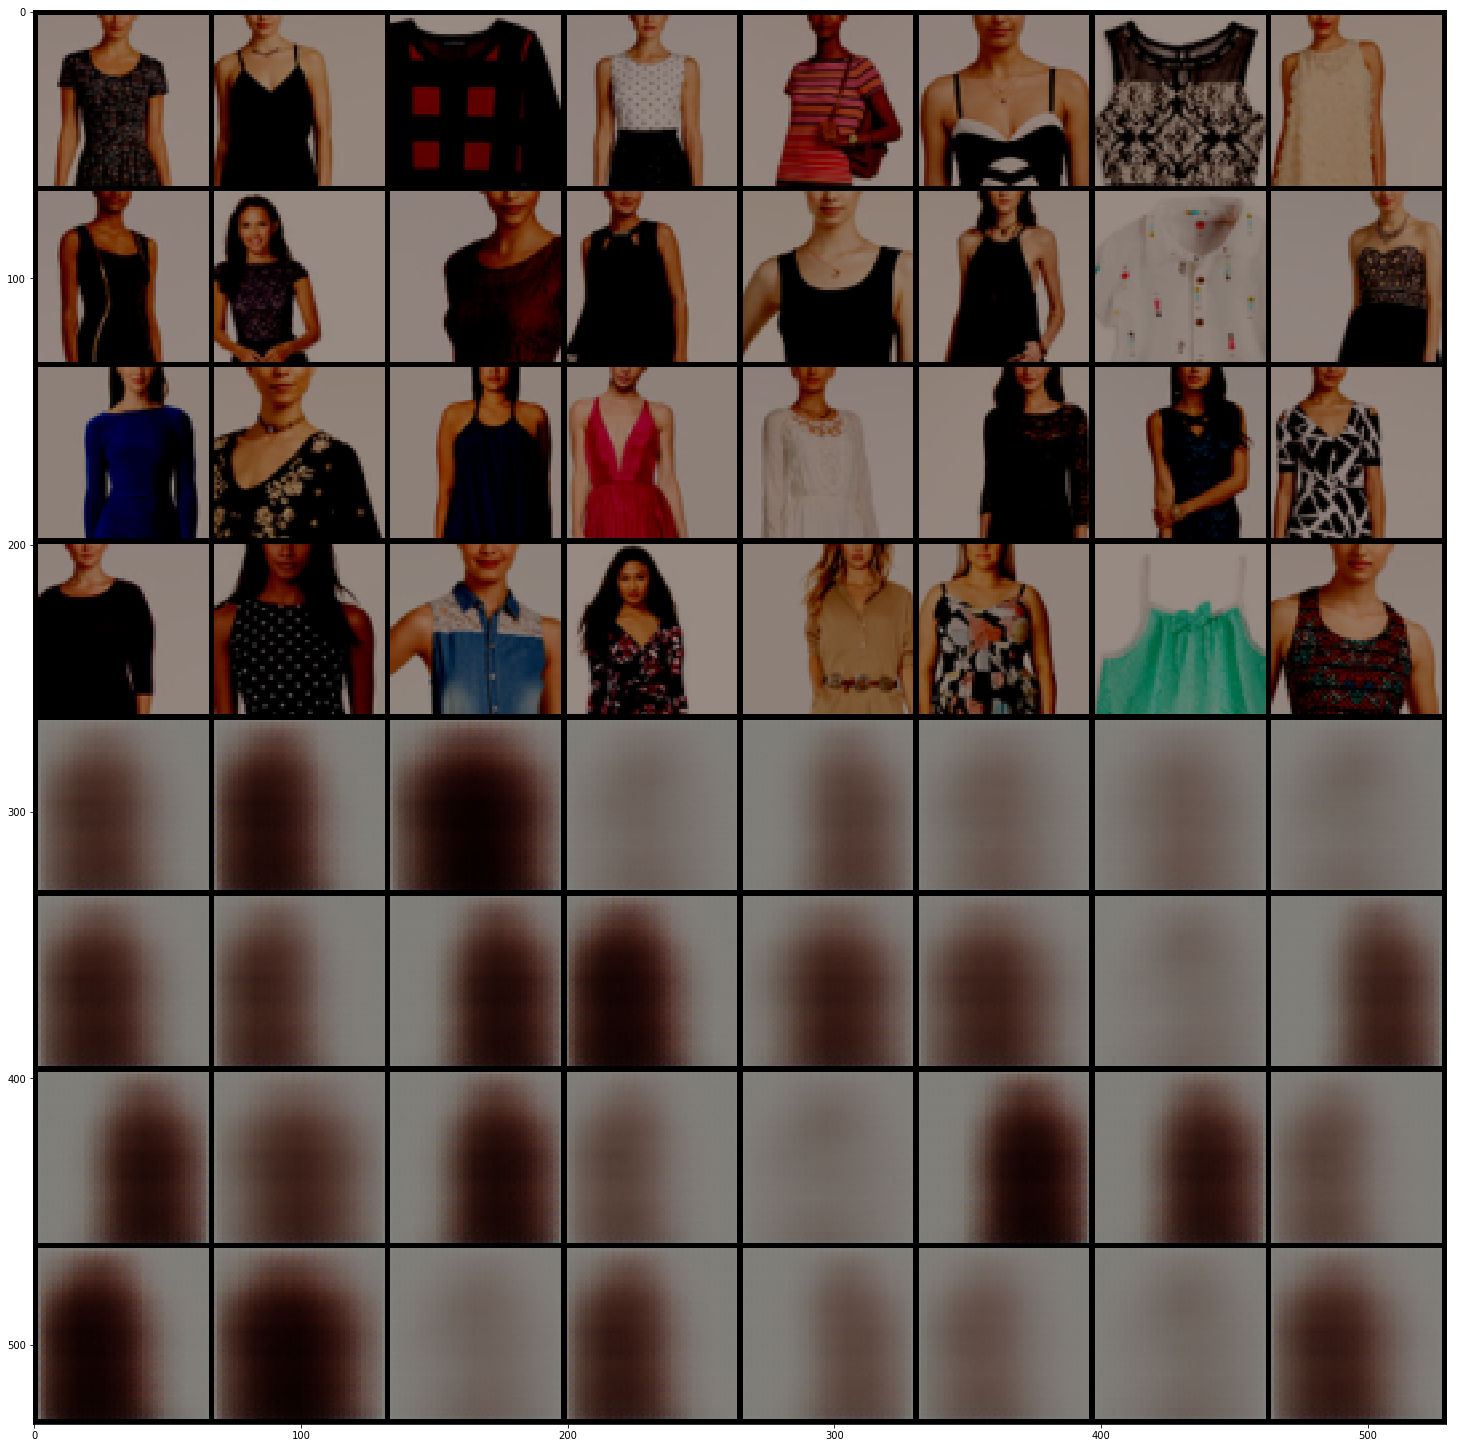

In [173]:
# Plot reconstructions
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get a batch of data
for batch, labels in test_loader:
    break

# Reconstruct data using Joint-VAE model
recon = viz.reconstructions(batch)

plt.figure(figsize=(26,26))
plt.imshow(np.rot90(np.transpose(recon.numpy(),(2,1,0)),k=3));
#plt.savefig("sample_images/306/64/crop_xint64_e10_b17_c3d3_gam20_reconstructions.png",dpi=200)

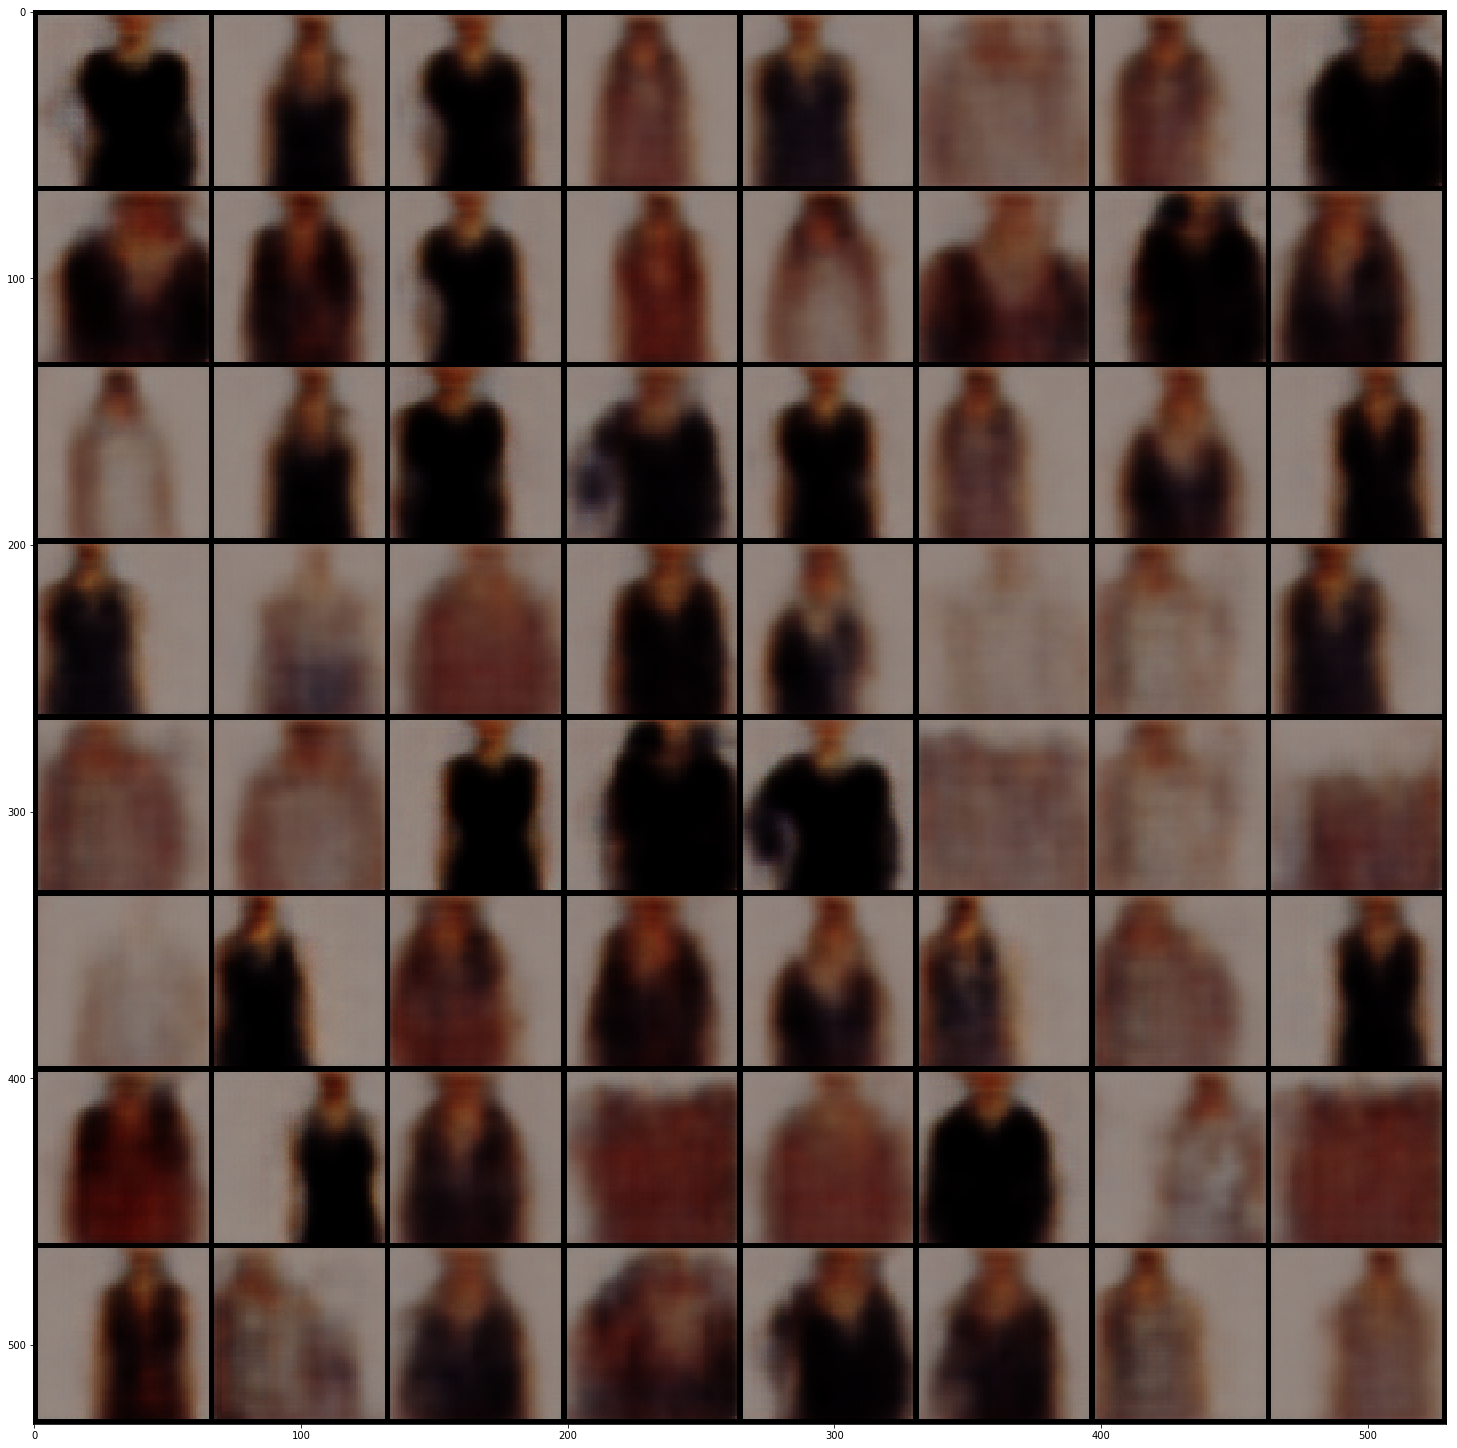

In [158]:
# Plot samples
samples = viz.samples()

plt.figure(figsize=(26,26))
#plt.imshow(samples.numpy()[0, :, :],cmap='gray');
plt.imshow(np.rot90(np.transpose(samples.numpy(),(2,1,0)),k=3));
#plt.savefig("sample_images/306/64/croptotop_64x64_e110_b200_c10d10_gam20.png",dpi=200)

#### Traverses all latent dimensions one by one and plots a grid of images where each row corresponds to a latent traversal of one latent dimension

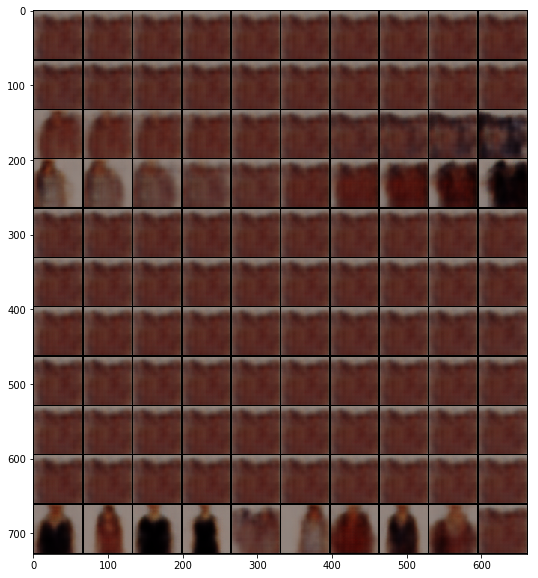

In [161]:
# Plot all traversals
traversals = viz.all_latent_traversals(size=10)

plt.figure(figsize=(10,10))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
#plt.savefig("sample_images/306/64/croptotop_64x64_e110_b200_c10d10_gam20_all_traversals_n20.png",dpi=200)

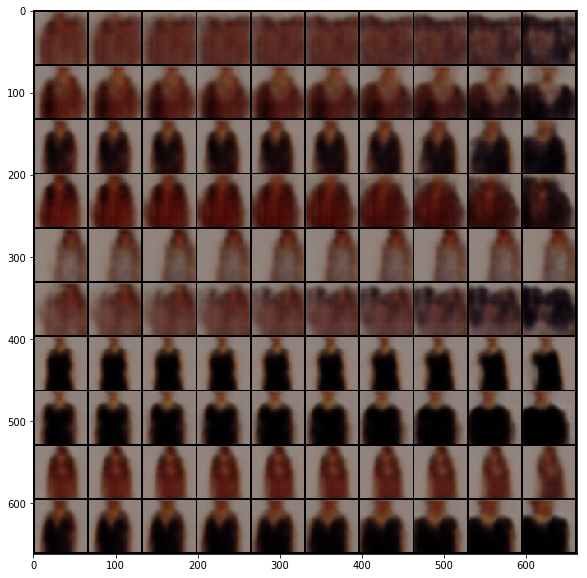

In [162]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(10,10))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
#plt.savefig("sample_images/306/64/croptotop_64x64_e110_b200_c10d10_gam20.png_traversals2100.png",dpi=200)

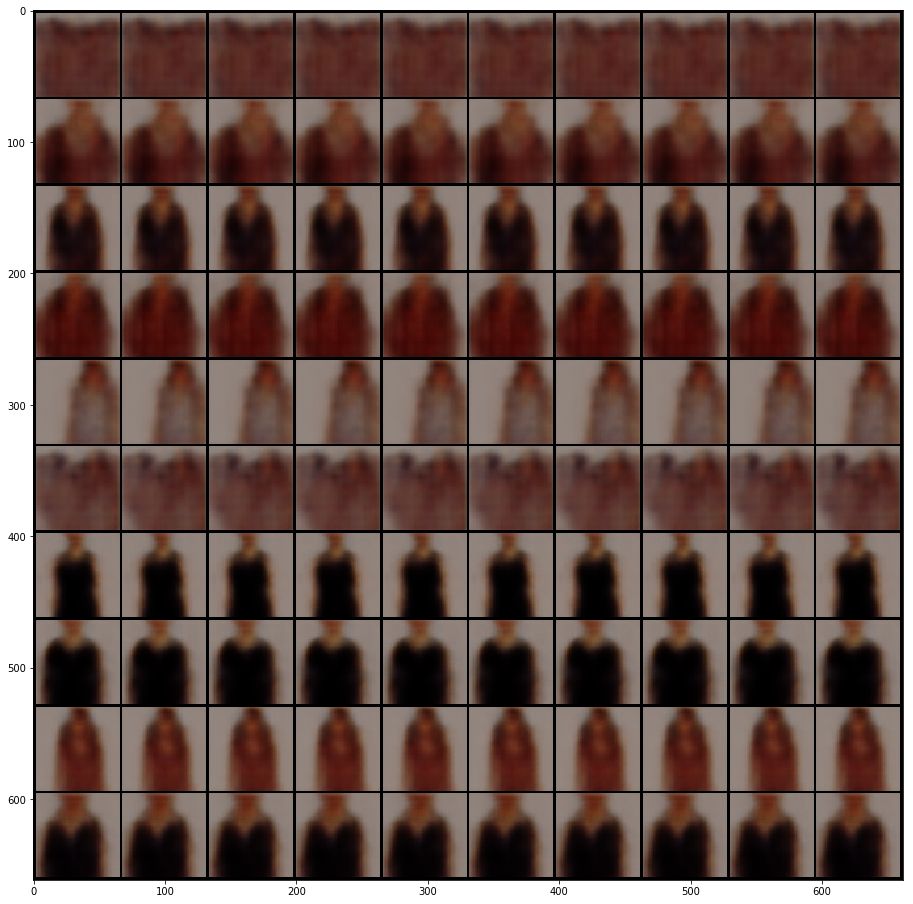

In [163]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=1, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(16,16))
plt.imshow(traversals.numpy()[0, :, :]);
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
#plt.savefig("sample_images/306/64/croptotop_64x64_e130_b200_c20d20_gam30_traversals1100.png",dpi=200)

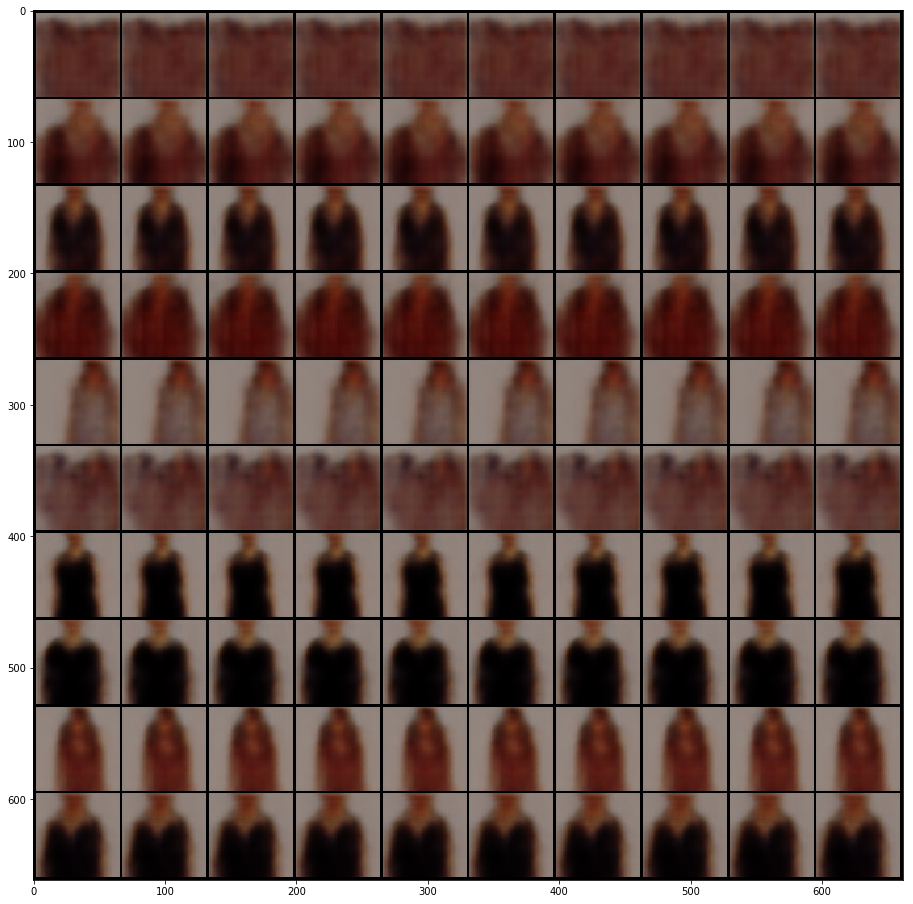

In [164]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=9, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(16,16))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
#plt.savefig("sample_images/306/64/croptotop_64x64_e130_b200_c20d20_gam30_traversals9100.png",dpi=200)

In [ ]:
!ls

### Save Model

In [ ]:
model_name = "croptotop_64x64_e130_b200_c20d20_gam30.pth"

In [ ]:
torch.save(model.state_dict(),"trained_models" + "statedict_" + model_name) # save state dict
torch.save(model, model_name) # save full model

In [ ]:
print("Done training: ",model_name)

#### Restore Model from State Dict

In [ ]:
sd_model = VAE(latent_spec=latent_spec, img_size=(3, 64, 64))
sd_model.load_state_dict(torch.load("statedict_" + model_name))

#### Restore Full Model
* Note in this case the serialized data is bound to the specific classes and exact directory strucutre used.

In [ ]:
full_model = torch.load(model_name)

In [ ]:
type(full_model)

In [ ]:
type(sd_model)

In [ ]:
!ls